# Fitting Emission Lines with Prospector

This notebook outlines the basic of fitting emission lines with Prospector. While optimization routines for fitting emission lines are common, Prospector has the ability to probe the full joint posterior between the continuum and all individual emission lines. These contain additional information that other codes are not able to incorporate.

## Environment

Let's initialize the environment.

In [1]:
import time, sys, os
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot
import corner

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Basic Idea

The first thing we need to do is define a Normal/Gaussian.

In [2]:
def gaussian(mu, std, x):    
    dif = x - mu
    norm = 1. / sqrt(2*pi) / std
    return norm * exp(-0.5 * square(dif/std))

Let's start with a toy model: a noisy Gaussian.

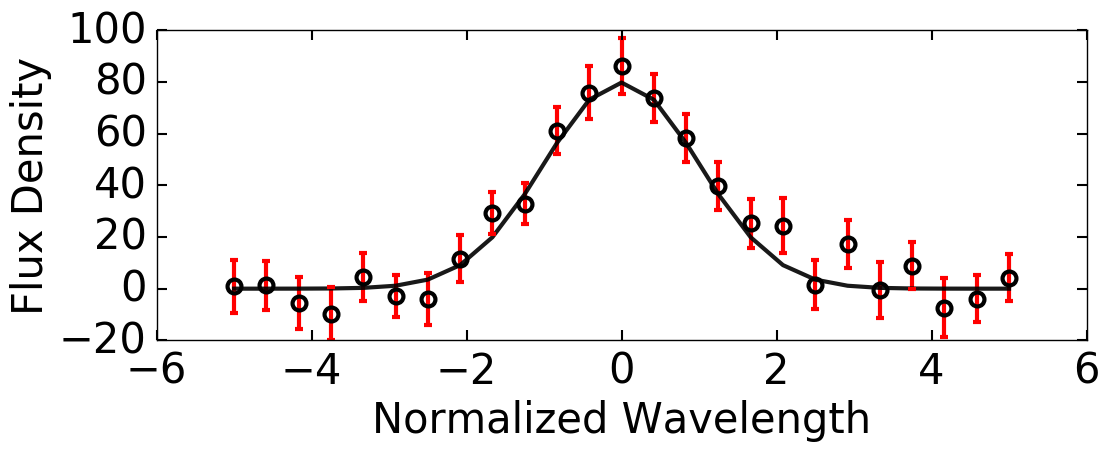

In [3]:
Ntheta, Ndata = 3, 25 # number of parameters, data points
mu, sigma, alpha = 0., 1., 200. # parameters of our fit: mean, standard deviation, and amplitude
theta_true = array([mu, sigma, alpha])
noise = 10. # background noise
x = linspace(mu-5*sigma, mu+5*sigma, Ndata) # observed grid
y = gaussian(0,1,x) # normal
y *= alpha # scale
y_err = normal(noise, size=25)
y_obs = normal(y, y_err)

figure(figsize=(12,4))
plot(x, alpha * gaussian(mu, sigma, x), lw=3, alpha=0.9, color='black')
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='red', lw=3, linestyle='None')
xlabel('Normalized Wavelength')
ylabel('Flux Density')

For our observed set of flux densities $\mathbf{\hat{F}}$ with associated covariance $\mathbf{\hat{C}}$, our emission line model is just $\mathbf{F}(\boldsymbol{\theta} = \lbrace \mu, \sigma, \alpha \rbrace) = \alpha\mathcal{N}(\boldsymbol{\lambda} | \mu, \sigma^2) $ where $\mathcal{N}(x|\mu,\sigma^2)$ is the Normal distribution with mean $\mu$ and variance $\sigma^2$, $\alpha$ is our line amplitude, and $\boldsymbol{\lambda}$ is the set of wavelengths corresponding to our observed flux densities.

Our likelihood is then simply

$$ P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = \mathcal{N}\left[\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \:|\: \mathbf{0}, \mathbf{\hat{C}} \right] $$

where $\Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) \equiv \mathbf{F}(\boldsymbol{\theta}) - \mathbf{\hat{F}}$. The corresponding log-likelihood is then

$$ \ln P(\mathbf{\hat{F}} \,|\, \boldsymbol{\theta}) = -\frac{1}{2}\Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} $$

where $Z_{\mathbf{\hat{F}}}$ is a normalization constant.

If we assume a (multivariate) Normal prior on $\boldsymbol{\theta}$ with mean $\boldsymbol{\mu}_{\boldsymbol{\theta}}$ and covariance $\mathbf{C}_{\boldsymbol{\theta}}$ such that

$$ P(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} \,|\, \boldsymbol{\mu}_{\boldsymbol{\theta}}, \mathbf{C}_{\boldsymbol{\theta}}) \quad, $$

our posterior then simply becomes 

$$ \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = -\frac{1}{2} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) + Z_{\mathbf{\hat{F}}} -\frac{1}{2} \Delta\boldsymbol{\theta}^T \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} + Z_{\boldsymbol{\theta}} $$

where $\Delta\boldsymbol{\theta} \equiv \boldsymbol{\mu}_{\boldsymbol{\theta}} - \boldsymbol{\theta}$.

In [4]:
# define prior
mean_theta, cov_theta = array([0., 1., 200.]), diag(array([2., 0.25, 50.])**2) # mean and covariance for [mu, sigma, alpha]
prec_theta = inv(cov_theta) # precision matrix

# define data
mean_data, cov_data = y_obs, diag(y_err**2) # vector and matrix form for the data
prec_data = inv(cov_data) # precision matrix

For completeness, we note that our constants are equal to

$$ 
Z_{\mathbf{\hat{F}}} = -\frac{1}{2} ( N_{\mathbf{\hat{F}}} \ln 2\pi + \ln|\mathbf{\hat{C}}| ) \quad , \quad 
Z_{\boldsymbol{\theta}} = -\frac{1}{2} ( N_{\boldsymbol{\theta}} \ln 2\pi + \ln|\mathbf{C}_{\boldsymbol{\theta}}| ) \quad .
$$

To evaluate the log-determinant, we will take advantage of **Cholesky decomposition** to decompose our covariance matrix such that the log-determinant simply becomes

$$ \ln|\mathbf{C}| = \ln|\mathbf{L} \mathbf{L}^T| = \ln |\mathbf{L}|^2 = 2\ln \left[ \prod_i L_{ii} \right] = 2 \sum_i \ln L_{ii} \quad .$$

In [5]:
# computing constants
cov_cho_theta = linalg.cholesky(cov_theta) # cholesky decomposition
lnorm_theta = -0.5*(Ntheta*log(2*pi) + 2*sum(log(diag(cov_cho_theta)))) # compute ln(norm)

cov_cho_data = linalg.cholesky(cov_data) # cholesky decomposition
lnorm_data = -0.5*(Ndata*log(2*pi) + 2*sum(log(diag(cov_cho_data)))) # compute ln(norm)

In [6]:
# define emission line model
def emline(theta):
    mu, sigma, alpha = theta
    return alpha * gaussian(mu, sigma, x)

# define ln(prior)
def lnprior(theta):
    dtheta = theta - mean_theta
    sqdist = dot(dot(dtheta.T, prec_theta), dtheta)
    return -0.5*sqdist + lnorm_theta

# define ln(likelikehood)
def lnlike(theta):
    model = emline(theta)
    delta = model - mean_data
    sqdist = dot(dot(delta.T, prec_data), delta)
    return -0.5*sqdist + lnorm_data

# define ln(posterior)
def lnpost(theta):
    return lnlike(theta) + lnprior(theta)

## Standard Approach: Optimization

We can easily find the *maximum a posteriori* (MAP) solution using a minimization routine, as shown below.

In [7]:
from scipy.optimize import minimize

MAP solution: [  3.02701115e-02   1.06232921e+00   2.16022384e+02]
Truth: [   0.    1.  200.]


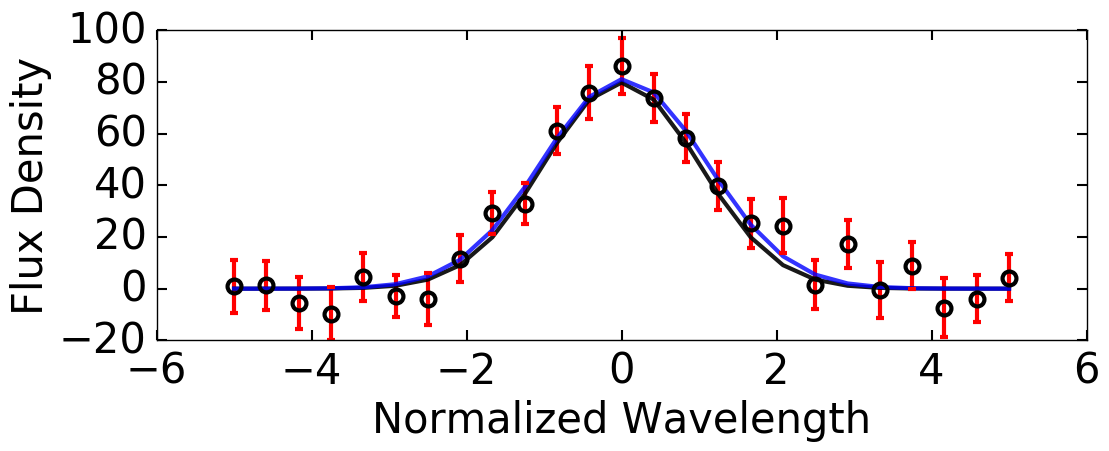

In [8]:
def neglnpost(theta):
    return -lnpost(theta)

theta = array([0.5,1.1,80.])
results = minimize(neglnpost, theta, method='Nelder-Mead')

figure(figsize=(12,4))
plot(x, emline(theta_true), lw=3, alpha=0.9, color='black')
plot(x, emline(results.x), lw=3, alpha=0.8, color='blue')
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='red', lw=3, linestyle='None')
xlabel('Normalized Wavelength')
ylabel('Flux Density')
print 'MAP solution: {0}'.format(results.x)
print 'Truth: {0}'.format(theta_true)

## Probing the Posterior with Hamiltonian Monte Carlo

We, however, are interested in probing the full posterior, not just the MAP solution. Although there are many possible ways to do this, we decide use **Hamiltonian Monte Carlo (HMC)** to take advantage of the fact that (1) our likelihood surface is smooth and (2) the gradients are analytic.

### Hamiltonian Dynamics

In brief, we can sample from the distribution by simulating a particle "rolling" around the potential with position $\mathbf{q}$ and momentum $\mathbf{p}$ such that 

$$ P(\mathbf{q}, \mathbf{p}) = \frac{1}{Z} \exp\left[ -\frac{H(\mathbf{q}, \mathbf{p})}{T} \right] = \frac{1}{Z} \exp\left[ -\frac{U(\mathbf{q})}{T} \right] \exp\left[ -\frac{K(\mathbf{p})}{T} \right] $$

where the Hamiltonian $H(\mathbf{q},\mathbf{p}) = U(\mathbf{q}) + K(\mathbf{p})$ is just a sum over the potential energy $U(\mathbf{q})$ and kinetic energy $K(\mathbf{p})$ of the particle, $T$ is the temperature of the system, and $Z$ is a normalizing constant.

Letting:
- our position $\mathbf{q} \equiv \boldsymbol{\theta}$ be our parameters of interest, 
- our momentum $\mathbf{p} \equiv \mathbf{M} \boldsymbol{\dot{\theta}}$ be the change in our parameters of interest multiplied by a **mass matrix** $\mathbf{M}$, 
- our potential energy $U(\mathbf{q}) = −\ln P(\mathbf{q} \,|\, \mathbf{\hat{F}}) $ be the negative log of our posterior, 
- and our kinetic energy $K(p) = \frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p}$ be in a standard quadratic form, 

we get

$$ P(\mathbf{q}, \mathbf{p}) \propto \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \, P(\mathbf{q} \,|\, \mathbf{\hat{F}}) $$

where we have set $T=1$.

Since the Hamiltonian is conserved, the system evolves according to Hamilton's equations such that

$$ 
\frac{\partial \mathbf{q}}{\partial t} = \nabla_{\mathbf{p}} K = \mathbf{M}^{-1} \mathbf{p} \quad , \quad 
\frac{\partial \mathbf{p}}{\partial t} = - \nabla_{\mathbf{q}} U = \nabla_{\mathbf{q}} \ln P( \mathbf{q} \,|\, \mathbf{\hat{F}})
$$

where $U(\boldsymbol{\theta})$ is defined as above. 

In [9]:
mass = eye(Ntheta) # define mass matrix as identity
inv_mass = inv(mass)

# define potential energy
def potential(q):
    return -lnpost(q)

# define potential energy gradient
def potential_grad(q):
    return -lnpost_grad(q)

# define kinetic energy
def kinetic(p):
    return 0.5 * dot(dot(p.T, inv_mass), p)

def kinetic_grad(p):
    return dot(inv_mass, p)

def hamiltonian(q, p):
    return potential(q) + kinetic(p)

### Our Potential/Posterior Gradients

In our original notation, the gradient of our log-posterior can be written as

$$ \nabla_{\boldsymbol{\theta}} \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = -\nabla_{\boldsymbol{\theta}} \mathbf{F}(\boldsymbol{\theta})^T \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \boldsymbol{\theta}^T \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} \quad . $$

Given that $\mathbf{F}(\boldsymbol{\theta} = \lbrace \mu, \sigma, \alpha \rbrace) = \alpha \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu, \sigma^2)$, the partials can be written as:

$$
\frac{\partial \mathbf{F}}{\partial \mu} = \sigma^{-2} (\boldsymbol{\lambda} - \mu) \bullet \alpha \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu, \sigma^2) 
= \boxed{ \sigma^{-2} (\boldsymbol{\lambda} - \mu) \bullet \mathbf{F}(\boldsymbol{\theta}) } \\
\frac{\partial \mathbf{F}}{\partial \sigma} = (\sigma^{-3} (\boldsymbol{\lambda} - \mu)^2 - \sigma^{-1}) \bullet \alpha \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu, \sigma^2) 
= \boxed{ (\sigma^{-3} (\boldsymbol{\lambda} - \mu)^2 - \sigma^{-1}) \bullet \mathbf{F}(\boldsymbol{\theta}) } \\
\frac{\partial \mathbf{F}}{\partial \alpha} = \mathcal{N}(\boldsymbol{\lambda} \,|\, \mu, \sigma^2) 
= \boxed{ \alpha^{-1} \bullet \mathbf{F}(\boldsymbol{\theta}) }
$$

where $\bullet$ indicates element-wise multiplication (i.e. the Hadamard product). Since by definition the gradient of $\boldsymbol{\theta}$ with respect to $\boldsymbol{\theta}$ is just the identity matrix, after defining

$$ \mathbf{G}(\boldsymbol{\theta}) \equiv 
\begin{bmatrix}
\mathbf{F}(\boldsymbol{\theta}) \\
\mathbf{F}(\boldsymbol{\theta}) \\
\mathbf{F}(\boldsymbol{\theta})
\end{bmatrix} \quad , \quad
\mathbf{H}(\boldsymbol{\theta}) \equiv
\begin{bmatrix}
\sigma^{-2} (\boldsymbol{\lambda} - \mu) \\
\sigma^{-3} (\boldsymbol{\lambda} - \mu)^2 - \sigma^{-1} \\
\alpha^{-1}
\end{bmatrix}
$$

our gradient can be written as

$$ \nabla_{\boldsymbol{\theta}} \ln P(\boldsymbol{\theta} \,|\, \mathbf{\hat{F}}) = - \left[ \mathbf{H}(\boldsymbol{\theta}) \bullet \mathbf{G}(\boldsymbol{\theta}) \right] \mathbf{\hat{C}}^{-1} \Delta\mathbf{\hat{F}}(\boldsymbol{\theta}) - \mathbf{C}_{\boldsymbol{\theta}}^{-1} \Delta\boldsymbol{\theta} \quad . $$

In [10]:
# define ln(prior) gradient
def lnprior_grad(theta):
    dtheta = theta - mean_theta
    grad = dot(prec_theta, dtheta)
    return -grad

# define ln(likelikehood) gradient
def lnlike_grad(theta):
    mu, sigma, alpha = theta
    model = emline(theta)
    delta = model - mean_data
    model_matrix = tile(model, Ntheta).reshape(Ntheta, Ndata)
    dmu = sigma**-2 * (x - mu) # linear in x
    dsigma = sigma**-3 * (x - mu)**2 - sigma**-1 # quadratic in x
    dalpha = alpha**-1 * ones(Ndata) # constant in x
    deriv_matrix = array([dmu, dsigma, dalpha])
    res_matrix = deriv_matrix * model_matrix
    grad = dot(dot(res_matrix, prec_data), delta)
    return -grad

# define ln(posterior) gradient
def lnpost_grad(theta):
    return lnlike_grad(theta) + lnprior_grad(theta)

### Evolving the System

We can numerically evolve our system for $L$ small timesteps $\epsilon$ using the **leapfrog method**:

\begin{align}
\textrm{Initial momentum half step:}& \quad \mathbf{p}(t+\epsilon/2) = \mathbf{p}(t) + \epsilon/2 \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t)) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+\epsilon) = \mathbf{q}(t) + \epsilon \times \nabla_{\mathbf{p}} K(t+\epsilon/2) \\
\textrm{Momentum leapfrog:}& \quad \mathbf{p}(t+\epsilon+\epsilon/2) = \mathbf{p}(t+\epsilon/2) + \epsilon \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t+\epsilon)) \\
\vdots \\
\textrm{Momentum leapfrog:}& \quad \mathbf{p}(t+(L-1)\epsilon+\epsilon/2) = \mathbf{p}(t+(L-2)\epsilon+\epsilon/2) + \epsilon \times -\nabla_{\mathbf{q}} U(\mathbf{q}(t+(L-1)\epsilon)) \\
\textrm{Position leapfrog:}& \quad \mathbf{q}(t+L\epsilon) = \mathbf{q}(t+(L-1)\epsilon) + \epsilon \times \nabla_{\mathbf{p}} K(t+(L-1)\epsilon+\epsilon/2) \\
\textrm{Final momentum half step:}& \quad \mathbf{p}(t+L\epsilon) = \mathbf{p}(t+(L-1)\epsilon+\epsilon/2) + \epsilon/2 \times --\nabla_{\mathbf{q}} U(\mathbf{q}(t+L\epsilon)) \\
\end{align}

In [11]:
# define HMC leapfrog integrator
def leapfrog_integrate(L, dt, q, p, return_chain=False):
    q_chain, p_chain = [], []
    q_t, p_t = q.copy(), p.copy() # initialize (position, momentum)
    p_t = p_t - 0.5 * dt * potential_grad(q_t) # initial momentum half-step
    p_chain.append(p_t)
    q_t = q_t + dt * kinetic_grad(p_t) # initial position step
    q_chain.append(q_t)
    for t in xrange(L):
        p_t = p_t - dt * potential_grad(q_t) # momentum step
        p_chain.append(p_t)
        q_t = q_t + dt * kinetic_grad(p_t) # position step
        q_chain.append(q_t)
    p_t = p_t - 0.5 * dt * potential_grad(q_t) # final momentum half-step
    p_chain.append(p_t)
    
    if return_chain:
        return q_t, -p_t, array(q_chain), array(p_chain) # negate momentum
    else:
        return q_t, -p_t

### HMC Algorithm

First, we change the momentum (i.e. give the particle a "kick" in a random direction) by sampling from our energy distribution 

$$ \mathbf{p} \sim \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \propto \mathcal{N}(\mathbf{p} \,|\, \mathbf{0}, \mathbf{M}) $$

which is proportional to a multivariate Normal with mean $\mathbf{0}$ and covariance $\mathbf{M}$.

Next, we propose a new state using Hamiltonian dynamics. Starting at $(\mathbf{q}, \mathbf{p})$, we evolve the system for $L$ steps of size $\epsilon$. The momentum variables are then negated (although this rarely needs to be done in practice), leaving us with the proposed state $(\mathbf{q}^*, \mathbf{p}^*)$.

Finally, we perform a **Metropolis update**, accepting the proposed state with probability

$$ \min \left\lbrace 1, \, \exp\left[-H(\mathbf{q}^*, \mathbf{p}^*) + H(\mathbf{q}, \mathbf{p}) \right] \right\rbrace = \min \left\lbrace 1, \, \exp\left[-U(\mathbf{q}^*) + U(\mathbf{q}) - K(\mathbf{p}^*) + K(\mathbf{p}) \right] \right\rbrace $$

In [12]:
# define momentum kick
def sample_p(mass):
    return multivariate_normal(mean=zeros(Ntheta), cov=mass)

# metropolis probability
def metro_prob(q, p, q_new, p_new):
    prob = exp(-hamiltonian(q_new, p_new) + hamiltonian(q, p))
    return min(1, prob)

# HMC update
def hmc_update(theta, L, dt, mass, adaptive=False):
    q, p = theta.copy(), sample_p(mass) # initial (position, momentum)
    q_out, p_out, q_chain, p_chain = leapfrog_integrate(L, dt, q, p, return_chain=True) # final (position, momentum)
    if metro_prob(q, p, q_out, p_out) > rand(): # accept
        if adaptive:
            return q_out, optimize_dt(dt, p_chain) # return new position and new dt
        else:
            return q_out # return new position
    else: # reject
        if adaptive:
            return q, optimize_dt(dt, p_chain) # return old position and new dt
        else:
            return q # return old position

### Tuning Hyperparameters and Optimizing Samples

#### Adaptive Updates

Going back to our leapfrog integrator, we note that while the timestep $\epsilon$ is constrained by the parameter with the smallest variance, the total integration time $L\epsilon$ is instead set by the parameter with the largest variance. In our case, these span a pretty large range of scales: $\Delta\sigma$ and $\Delta \mu$ are around ~10-100x smaller than $\Delta \alpha$.

To get around this, we adaptively modify our timestep in each dimension such that $\Delta\mathbf{t} = \epsilon \times \mathbf{T}_{\boldsymbol{\theta}}$ scales with a vector $\mathbf{T}_{\boldsymbol{\theta}}$ such that we can use $L \sim 25$ for our total number of timesteps. We first initialize $\Delta \mathbf{t}$ as ~1% of the marginal standard deviation via $\Delta \mathbf{t} = 10^{-2} \left[\mathbf{C}_{\boldsymbol{\theta}} \mathbf{1} \right]^{1/2}$ where $\mathbf{1}$ is a vector of ones. Due to the quadratic nature of our posterior, we expect the evolution in $\mathbf{q}$ and $\mathbf{p}$ of our particle to be oscillatory. As a result, in $L \sim 25$ steps, we want to complete $\sim 2.5$ full periods in each parameter to appropriate sample the posterior. We thus want the particle to move $\sim 20%$ of a period in each step. By tracking roots in $\mathbf{p}$, we can determine where and when a particle changes direction and tune our parameters accordingly to guarantee $\gtrsim \, 5$ inflection points.

In [13]:
from scipy.optimize import fsolve # root solver

# get momentum roots
def get_roots(p_chain):
    Nsamps, Ntheta = p_chain[:-1].shape
    grid = arange(Nsamps)
    roots = []
    for i in xrange(Ntheta):
        def func(x): return interp(x, grid, p_chain[:-1,i]) # interpolation function
        sol = fsolve(func, grid) # solutions
        idx = unique(sol.round(0).astype(int)) # find root locations
        idx = idx[(idx>0) & (idx<Nsamps)]
        roots.append(idx)
    return roots

# optimize steps
def optimize_dt(dt, p_chain):
    L, dt_new = len(p_chain)-2, dt.copy()
    _, Ntheta = p_chain.shape
    roots = get_roots(p_chain)
    for i in xrange(Ntheta):
        Nturn = len(roots[i])
        if Nturn >= 5:
            Lturn = diff(roots[i]).mean() # average time for half a period
            dt_new[i] *= Lturn * 5. / L # decrease step size
        else:
            dt_new[i] *= 1.2 # increase stepsize by 20%
    return dt_new

#### Stochastic Updates

In addition to our adaptive sampling scheme defined above, we can also run into problems if we keep $L$ and $\Delta \mathbf{t}$ constant if we happen to hit particular harmonics of the gradient/potential. To mitigate these, we also allow 20% variation in $L$ and $\epsilon$ sampled uniformly.

### HMC Sampler

Putting this all together, our HMC sampler is defined below.

In [14]:
# hmc sampler
def hmc_sampler(theta, N, L, dt, mass, adaptive=False, stochastic=False, fvar=0.2, Nadapt=100):
    
    q = theta.copy()
    q_chain = []
    L_init, dt_init = copy(L), copy(dt)
    
    for n in xrange(N):
        if stochastic: # let L and dt slightly vary
            L= randint(L_init*(1-fvar), L_init*(1+fvar)+1e-10)
            dt = uniform(dt_init*(1-fvar), dt_init*(1+fvar))
        if adaptive and n < Nadapt:
            q, dt_init = hmc_update(q, L, dt, mass, adaptive) # HMC update w/ new dt
        else:
            q = hmc_update(q, L, dt, mass) # HMC update
        q_chain.append(q.copy())
        
    if adaptive: 
        return array(q_chain), dt
    else: 
        return array(q_chain)

### Generating Samples

Now that everything's set up, let's generate some samples.

In [15]:
L, dt = 25, 1e-2 * sqrt(dot(cov_theta, ones(Ntheta))) # length of chain, timesteps
Nsamples, Nadapt = 10000, 500
samples, dt_new = hmc_sampler(theta, Nsamples, L, dt, mass, adaptive=True, stochastic=True, Nadapt=Nadapt)
print 'Original dt:', dt
print 'New dt:', dt_new

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Josh\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Original dt: [ 0.02    0.0025  0.5   ]
New dt: [ 0.03796174  0.04178407  1.18974389]


As with a typical **Markov Chain Monte Carlo (MCMC)** sampler, our HMC sampler only generates independent samples from the posterior after it has **burned in** to the stationary distribution. Unlike a typical MCMC sampler, however, our HMC sampler burns in *extremely* fast by taking advantage of the gradient to roll down the potential (i.e. our posterior).

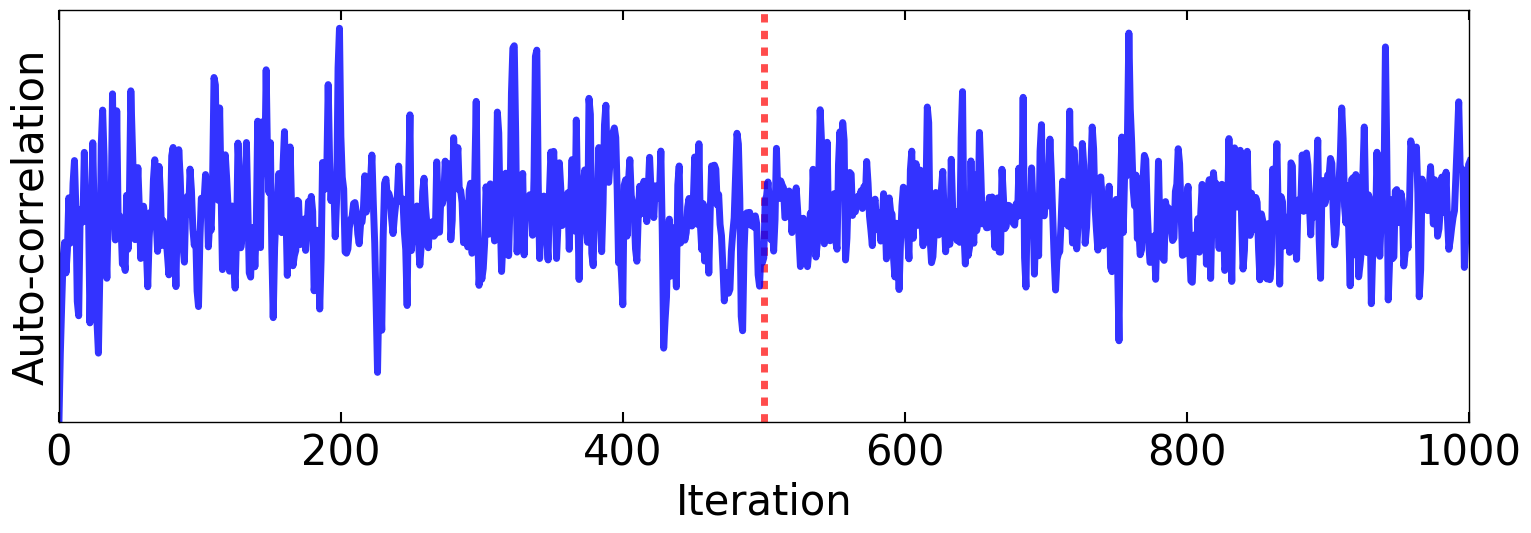

In [16]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(samples[i], samples[i+1]) for i in arange(Nsamples-1)]).flatten()
plot(arange(Nsamples-1), autocorr, lw=5, color='blue', alpha=0.8)
vlines(Nadapt,autocorr.min(),autocorr.max(), lw=5, alpha=0.7, linestyles='--', colors='red')
xlabel('Iteration')
ylabel('Auto-correlation')
ylim([autocorr.min(), autocorr.max()])
yticks([])
xlim([0, 2*Nadapt])
tight_layout()

Also unlike standard MCMC samplers, our HMC sampler is also quite efficient at generating independent samples.

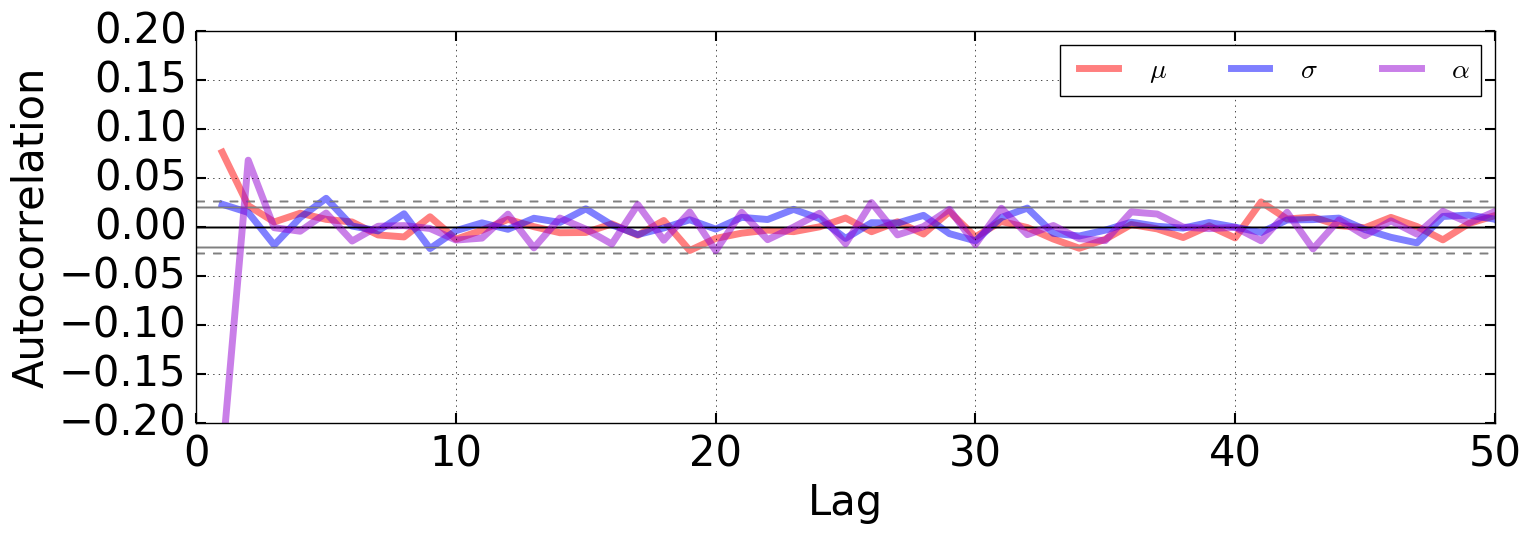

In [17]:
Nburnin = 500 # burn-in
varnames = [r'$\mu$', r'$\sigma$', r'$\alpha$']
varcolors = ['red', 'blue', 'darkviolet']

# plot autocorrelation lag
figure(figsize=(16,6))
h = [autocorrelation_plot(samples[Nburnin:,i], color=varcolors[i], lw=5, alpha=0.5, label=varnames[i])
     for i in xrange(Ntheta)]
xlim([0, 50])
ylim([-0.2,0.2])
legend(loc='best', fontsize=20, ncol=Ntheta)
tight_layout()

Let's now examine our samples.

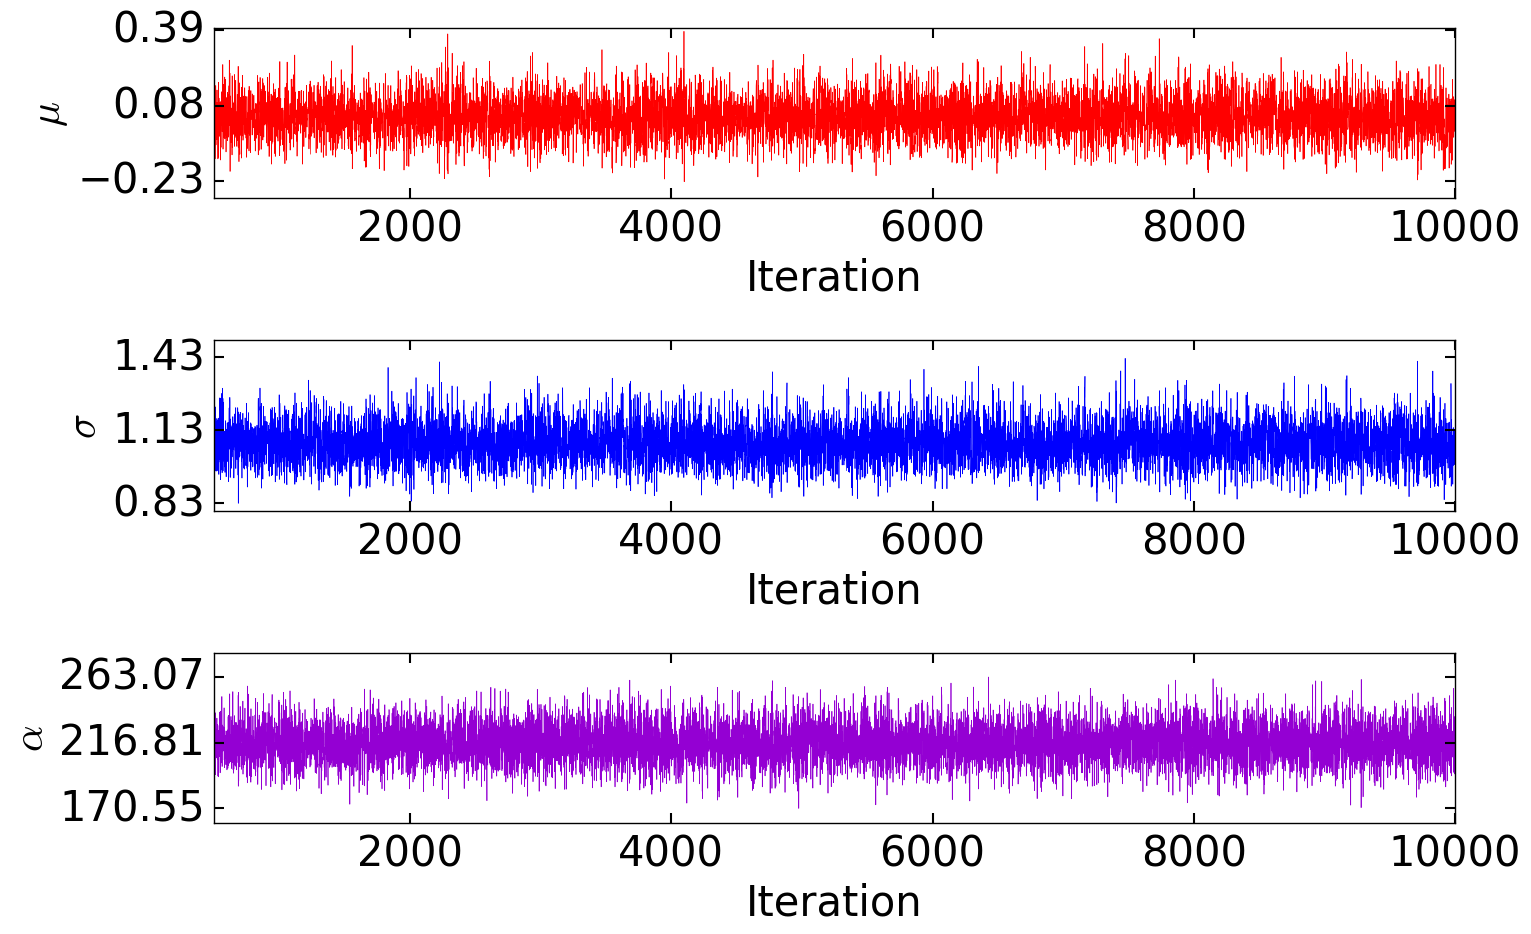

In [18]:
# plot trace
figure(figsize=(16,10))
for i in xrange(Ntheta):
    subplot(3,1,i+1)
    plot(arange(Nburnin,Nsamples), samples[Nburnin:,i], lw=0.5, color=varcolors[i])
    ymin, ymax = samples[Nburnin:,i].min(), samples[Nburnin:,i].max()
    yticks(linspace(ymin, ymax, 3).round(2))
    xlabel('Iteration')
    xlim([Nburnin, Nsamples])
    ylabel(varnames[i])
    tight_layout()

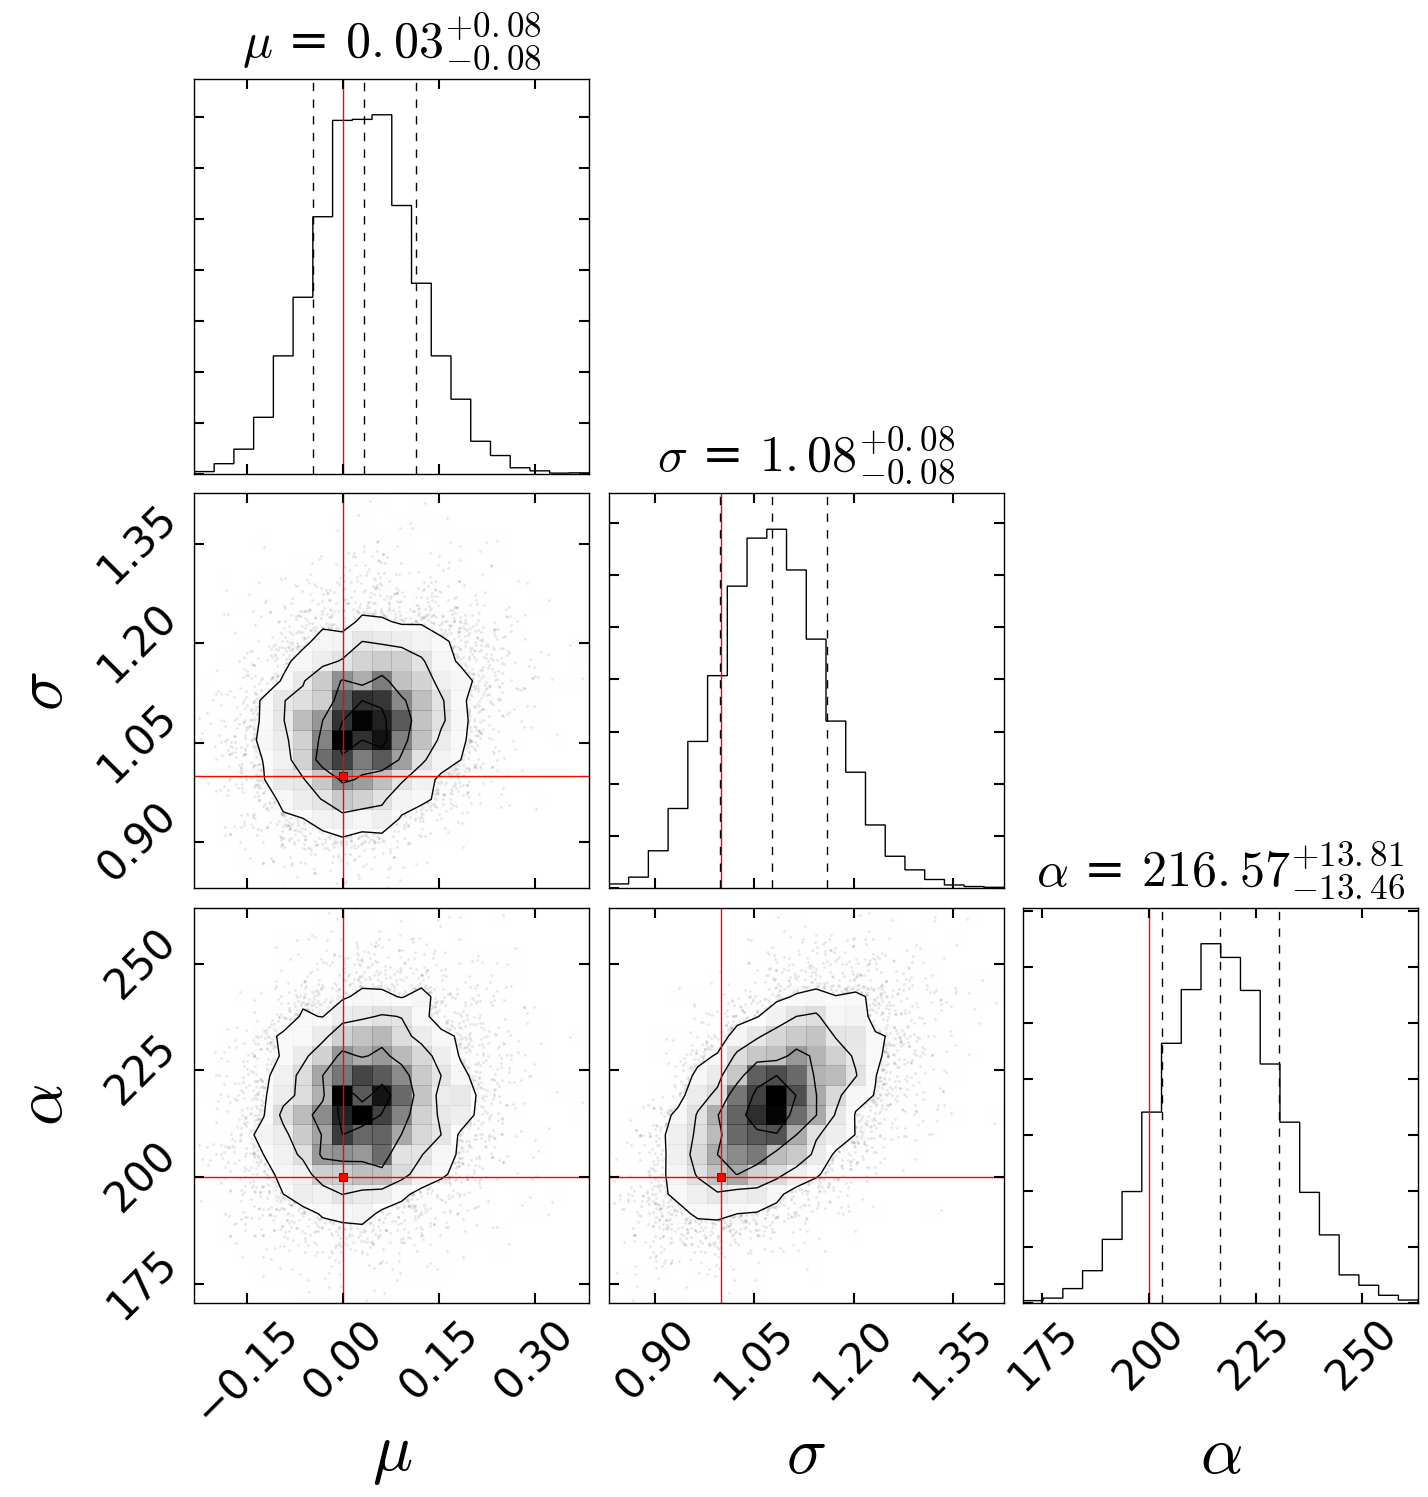

In [19]:
fig = corner.corner(samples[Nburnin:], quantiles=[.16, .50, .84],
                    labels=varnames, label_kwargs={'fontsize':48}, 
                    truths=theta_true, truth_color='red', 
                    show_titles=True, title_kwargs={'y':1.04},
                    fig=subplots(Ntheta,Ntheta,figsize=(15,15))[0])

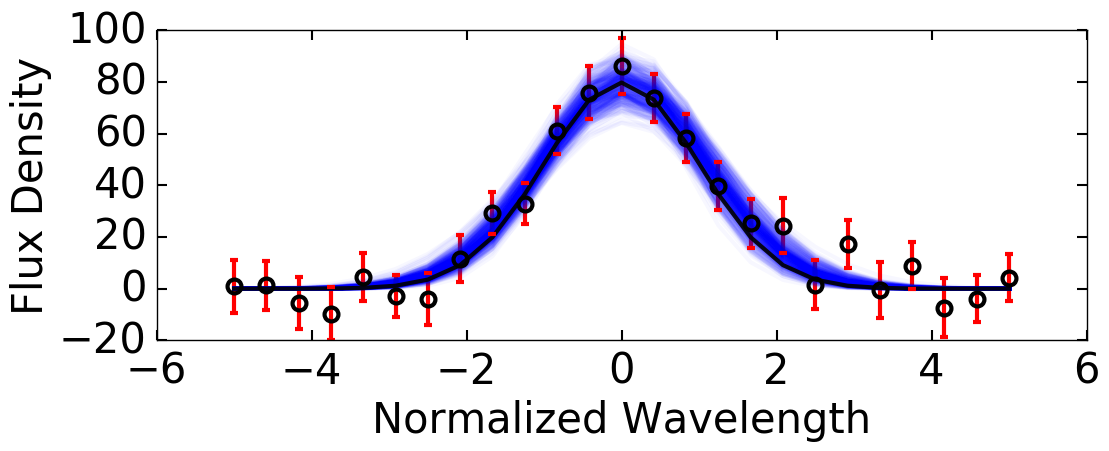

In [20]:
figure(figsize=(12,4))
[plot(x, emline(q), lw=3, alpha=0.03, color='blue') for q in samples[Nburnin::25]]
plot(x, emline(theta_true), lw=3, alpha=0.9, color='black')
errorbar(x, y_obs, yerr=y_err, marker='o', markerfacecolor='none', markeredgecolor='black', markeredgewidth=3,
         markersize=10, ecolor='red', lw=3, linestyle='None')
xlabel('Normalized Wavelength')
ylabel('Flux Density')